# Lab 10-4. ImageFolder

pytorch torchvision 에서는 이미지를 custom dataset 을 쉽게 만들 수 있게 ImageFolder 라는 기능을 제공합니다.

![image](https://user-images.githubusercontent.com/84179578/157383208-085e28d2-9356-4001-ad54-e6c2d813f373.png)

`ImageFolder` 를 사용하려면 아래와 같이 데이터 폴더 내에 이미지의 class 별로 폴더를 나누어 저장해야합니다.  

![image](https://user-images.githubusercontent.com/84179578/157383398-02e3633e-a241-479f-9c67-4d40363514d8.png)

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import os
import time
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore')


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

이번에 사용할 데이터셋은 가위바위보 데이터셋으로 가위, 바위, 보 세가지 클래스가 존재하고 각 클래스마다 100장의 이미지가 있습니다.  

아래의 폴더 구조로 되어 있습니다.

In [3]:
!tree custom_dataset

custom_dataset
├── paper
│   ├── 0.jpg
│   ├── 10.jpg
│   ├── 11.jpg
│   ├── 12.jpg
│   ├── 13.jpg
│   ├── 14.jpg
│   ├── 15.jpg
│   ├── 16.jpg
│   ├── 17.jpg
│   ├── 18.jpg
│   ├── 19.jpg
│   ├── 1.jpg
│   ├── 20.jpg
│   ├── 21.jpg
│   ├── 22.jpg
│   ├── 23.jpg
│   ├── 24.jpg
│   ├── 25.jpg
│   ├── 26.jpg
│   ├── 27.jpg
│   ├── 28.jpg
│   ├── 29.jpg
│   ├── 2.jpg
│   ├── 30.jpg
│   ├── 31.jpg
│   ├── 32.jpg
│   ├── 33.jpg
│   ├── 34.jpg
│   ├── 35.jpg
│   ├── 36.jpg
│   ├── 37.jpg
│   ├── 38.jpg
│   ├── 39.jpg
│   ├── 3.jpg
│   ├── 40.jpg
│   ├── 41.jpg
│   ├── 42.jpg
│   ├── 43.jpg
│   ├── 44.jpg
│   ├── 45.jpg
│   ├── 46.jpg
│   ├── 47.jpg
│   ├── 48.jpg
│   ├── 49.jpg
│   ├── 4.jpg
│   ├── 50.jpg
│   ├── 51.jpg
│   ├── 52.jpg
│   ├── 53.jpg
│   ├── 54.jpg
│   ├── 55.jpg
│   ├── 56.jpg
│   ├── 57.jpg
│   ├── 58.jpg
│   ├── 59.jpg
│   ├── 5.jpg
│   ├── 60.jpg
│   ├── 61.jpg
│   ├── 62.jpg
│   ├── 63.jpg
│   ├── 64.jpg
│   ├── 65.jpg
│   ├── 66.jpg
│   ├── 67.jpg
│   ├── 68.jpg
│   ├─

라벨은 폴더 순으로 paper, rock, scissor 각각 0, 1, 2 로 라벨링됩니다.  


(224, 224, 3)


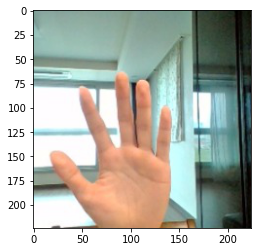

In [4]:
sample = plt.imread('custom_dataset/paper/0.jpg')
print(sample.shape)
plt.imshow(sample)

## ImageFolder 을 이용한 커스텀데이터셋 구축

In [5]:
transforms = transforms.Compose([   # Compose : Composes several transforms together.
    transforms.Resize((28,28)),
    transforms.ToTensor()
])


dataset = torchvision.datasets.ImageFolder(root="custom_dataset", transform=transforms)

In [6]:
for _, value in enumerate(dataset):
    data, label = value

    print(data.shape, '\n label :',label)
    break

torch.Size([3, 28, 28]) 
 label : 0


## Hyperparameter 설정 및 Dataloader

In [7]:
BATCH_SIZE =32
EPOCHS = 10

# train set, test set split 
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size


train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = False)

## Model

![image](https://user-images.githubusercontent.com/84179578/157394777-cfcc8b50-3a96-41c9-b9a9-f2832fd42d5d.png)


In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2), stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2), stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(5*5*32, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        # print(out.shape)   # 각 레이어에서 shape 확인할때 좋음
        out = self.layer2(out)
        # print(out.shape)
        out = out.reshape(out.shape[0], -1)
        # print(out.shape)
        out = self.fc(out)
        return out

In [9]:
# 모델이 잘 만들어졌는지 테스트

model = LeNet().to(device)
x = torch.randn(1,3,28,28).to(device)
print(model(x).shape)

torch.Size([1, 3])


## Train

In [10]:
total_batch = len(train_loader)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0000001)
criterion = nn.CrossEntropyLoss().to(device)


for epoch in range(EPOCHS):
    avg_cost = 0.0
    for num, data in enumerate(train_loader):
        imgs, labels = data
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        
        avg_cost += loss / total_batch
        
    print(f'epoch : {epoch+1}, cost = {avg_cost}')
        


epoch : 1, cost = 1.100920557975769
epoch : 2, cost = 1.100142240524292
epoch : 3, cost = 1.0998960733413696
epoch : 4, cost = 1.0997703075408936
epoch : 5, cost = 1.0996301174163818
epoch : 6, cost = 1.1000736951828003
epoch : 7, cost = 1.1003960371017456
epoch : 8, cost = 1.1002211570739746
epoch : 9, cost = 1.1008301973342896
epoch : 10, cost = 1.100608468055725


## Test

In [11]:
# score 계산
def accuracy_function(real, pred):               
    score = accuracy_score(real, pred)
    return score

In [12]:
model.eval()

test_loss = 0
test_pred=[]
test_y=[]
with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)
        test_loss += loss.item()/len(test_loader)
        test_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        test_y += y.detach().cpu().numpy().tolist()
    test_acc = accuracy_function(test_y, test_pred)

print(f'TEST    loss : {test_loss:.5f}    acc : {test_acc:.5f}')

TEST    loss : 1.09717    acc : 0.35000


## Model Save

In [15]:
torch.save(model.state_dict(), 'model/model.pth')

In [16]:
new_model = LeNet().to(device)

new_model.load_state_dict(torch.load('model/model.pth'))

<All keys matched successfully>

In [23]:
print(model.layer1[0].weight[0][0][0])
print(new_model.layer1[0].weight[0][0][0])

print(model.layer1[0].weight[0] == new_model.layer1[0].weight[0])

tensor([-0.0337,  0.1573,  0.1365], device='cuda:0', grad_fn=<SelectBackward>)
tensor([-0.0337,  0.1573,  0.1365], device='cuda:0', grad_fn=<SelectBackward>)
tensor([[[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]]], device='cuda:0')


In [21]:
print(new_model)

LeNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=800, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)
